<a id= 'top'></a>

# Linear Regression:


In this notebook, we are going to look at linear regression modeling of opening weekend sales of a data which was scraped from [IMDB](http://www.imdb.com), [Boxofficemojo]( http://www.boxofficemojo.com) and [The-Numbers](http://www.the-numbers.com/movie/budgets/all). 

<p>

The data set is consisting of 2687 movies with the following columns: 'rating', 'stars', 'link', 'year', 'rank', 'first_stars','title', 'director_stars', 'average_per_theater', 'theaters','adjusted_opening', 'adjusted_gross', 'percent_of_total', 'Rank','Production Budget', 'release date', 'Domestic Gross','Worldwide Gross'.

<p>

The dollar price value, such as Opening Wakened, Budget and etc., are corrected with [Consumer Price Index](http://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/)  which is provided by [U.S. Department of Labor Bureau of Labor Statistic](https://www.bls.gov/home.htm)

<p>

1. [Reading and processing the dataset](#1)
* [Transforming  categorical data to dummy variables](#2)
* [Normalize process](#3)
* [Getting a baseline with scikit learn regression model and Statsmodels](#4)
* [Feature selection](#5)
* [Second degree polynomial Features](#6)
* [Third degree polynomial Features](#7)


In [1]:
%load_ext watermark
%watermark -v -m -p pandas

from __future__ import print_function, division
import pandas as pd
import numpy as np
import seaborn as sns

from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.linear_model import RidgeCV
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

import cufflinks as cf
import plotly as pl
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Bar, Scatter, Figure, Layout
from plotly.graph_objs import *
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import patsy
import re

%matplotlib inline

CPython 3.5.2
IPython 5.1.0

pandas 0.18.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 16.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
layout = go.Layout(
    xaxis=dict(
        showgrid=False,
        zeroline=True,
        showline=True,
        mirror='ticks',
        gridcolor='#bdbdbd',
        #gridwidth=0,
        zerolinecolor='#969696',
        zerolinewidth=4,
        linecolor='#636363',
        tickfont=dict(
            family='',
            size=20,
            color='black'
        ),
        linewidth=6
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=True,
        showline=True,
        mirror='ticks',
        gridcolor='#bdbdbd',
        #gridwidth=0,
        zerolinecolor='#969696',
        zerolinewidth=4,
        linecolor='#636363',
        tickfont=dict(
            family='',
            size=20,
            color='black'
        ),
        linewidth=6
    )
)

In [3]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x.reshape(s,1),y)
    pred = rgr.predict(x.reshape(s,1))

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    

In [4]:
def PolynomialFeatures_labeled(input_df,power):
    '''Basically this is a cover for the sklearn preprocessing function. 
    The problem with that function is if you give it a labeled dataframe, it ouputs an unlabeled dataframe with potentially
    a whole bunch of unlabeled columns. 

    Inputs:
    input_df = Your labeled pandas dataframe (list of x's not raised to any power) 
    power = what order polynomial you want variables up to. (use the same power as you want entered into pp.PolynomialFeatures(power) directly)

    Ouput:
    Output: This function relies on the powers_ matrix which is one of the preprocessing function's outputs to create logical labels and 
    outputs a labeled pandas dataframe   
    '''
    poly = PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df



<p>
<a id= '1'></a>

## Reading and processing the dataset

[Return to top](#top)

In [5]:
df = pd.read_csv('imdb_bom_numbers.csv')
df.tail()

,Unnamed: 0,rating,stars,link,year,rank,first_stars,title,director_stars,average_per_theater,theaters,adjusted_opening,adjusted_gross,percent_of_total,Rank,Production Budget,release date,Domestic Gross,Worldwide Gross
2683,2683,7.3,"Bradley Cooper,Sienna Miller,Kyle Gallner,Cole...",/title/tt2179136/,2014,9893.0,Bradley Cooper,american sniper,Clint Eastwood,"$26,626","3,555","$94,656,000","$370,918,800",25.5%,854,"$58,000,000",12/25/2014,"$350,126,372","$547,326,372"
2684,2684,7.7,"Colin Firth,Taron Egerton,Samuel L. Jackson,Mi...",/title/tt2802144/,2014,9935.0,Colin Firth,kingsman: the secret service,Matthew Vaughn,"$11,982","3,204","$38,391,200","$135,299,500",28.4%,366,"$94,000,000",2/13/2015,"$128,261,724","$404,561,724"
2685,2685,7.0,"Oscar Isaac,Jessica Chastain,David Oyelowo,Ale...",/title/tt2937898/,2014,9945.0,Oscar Isaac,a most violent year,J.C. Chandor,"$1,961",818,"$1,603,500","$6,091,600",26.3%,2415,"$20,000,000",12/31/2014,"$5,749,134","$6,071,433"
2686,2686,7.6,"Emily Blunt,Josh Brolin,Benicio Del Toro,Jon B...",/title/tt3397884/,2015,9947.0,Emily Blunt,sicario,Denis Villeneuve,"$4,589","2,620","$12,022,400","$46,437,200",25.9%,1723,"$30,000,000",9/18/2015,"$46,889,293","$78,571,737"
2687,2687,6.0,"Anna Kendrick,Meryl Streep,Chris Pine,Emily Blunt",/title/tt2180411/,2014,9948.0,Anna Kendrick,into the woods,Rob Marshall,"$13,201","2,440","$32,211,700","$135,367,900",23.8%,980,"$50,000,000",12/25/2014,"$128,002,372","$203,502,372"


In [6]:
df.columns

Index(['Unnamed: 0', 'rating', 'stars', 'link', 'year', 'rank', 'first_stars',
       'title', 'director_stars', 'average_per_theater', 'theaters',
       'adjusted_opening', 'adjusted_gross', 'percent_of_total', 'Rank',
       'Production Budget', 'release date', 'Domestic Gross',
       'Worldwide Gross'],
      dtype='object')

In [7]:
df.title.describe()

count               2688
unique              2484
top       the karate kid
freq                   8
Name: title, dtype: object

In [8]:
df1 = df[['first_stars', 'director_stars',
          'adjusted_opening','theaters',
          'title','release date',
          'Production Budget','year']]

In [9]:
df1 = df1.sort(columns = 'year')

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



In [10]:
cpi = pd.read_html('http://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/')
cpi = cpi[0]
cpi1 = cpi[[0,13]].copy()
cpil = cpi1[2:].copy()
def cpi(x):
    return (240.007/float(x))
cpil['cpi1'] = cpil[13].apply(cpi)
cpil['year'] = cpil[0]
cpil_f = cpil[['year','cpi1']]

df2 = pd.merge(df1,cpil_f, on = 'year')


def integer(x):
    return( int (re.sub("[^0-9]","", x) ))

def adjusted (x,y):
    return (x*y)

df2['theaters'] = df2.theaters.apply(integer)

df2['budget'] = df2['Production Budget'].apply(integer)
df2['adjusted_budget'] = np.vectorize(adjusted)(df2['budget'],df2['cpi1'])

df2['adjusted_opening'] = df2['adjusted_opening'].apply(integer)


df2 = df2.rename(columns={'release date': 'release_date'})
df2['release_date'] = pd.to_datetime(df2['release_date'] ,infer_datetime_format=True)
df2['dayofyear'] = df2.release_date.dt.dayofyear
df2['dayoftheweek'] = df2.release_date.dt.dayofweek
df2['dayoftheweek'].replace([0,1,2,3,4,5,6],['Monday',
                                        'Tuesday',
                                        'Wednesday',
                                        'Thursday',
                                        'Friday',
                                        'Saturday',
                                        'Sunday'],inplace=True)
df2['year'] = df2.release_date.dt.year
df2['week'] = df2.release_date.dt.week
df2['month'] = df2.release_date.dt.month
df2 = df2.sort(columns = 'year')

df2 = df2.dropna(subset=['adjusted_budget'], how='all')

df2.tail()


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,first_stars,director_stars,adjusted_opening,theaters,title,release_date,Production Budget,year,cpi1,budget,adjusted_budget,dayofyear,dayoftheweek,week,month
2615,Eddie Redmayne,David Yates,75277700,4144,fantastic beasts and where to find them,2016-11-18,"$180,000,000",2016,1.0,180000000,180000000.0,323,Friday,46,11
2616,Auli'i Cravalho,Ron Clements,57296900,3875,moana,2016-11-23,"$150,000,000",2016,1.0,150000000,150000000.0,328,Wednesday,47,11
2604,Gerard Butler,Babak Najafi,21711200,3490,london has fallen,2016-03-04,"$60,000,000",2016,1.0,60000000,60000000.0,64,Friday,9,3
2600,Edgar Ramírez,Jonathan Jakubowicz,1772000,810,hands of stone,2016-08-26,"$20,000,000",2016,1.0,20000000,20000000.0,239,Friday,34,8
2625,Lucas Till,Chris Wedge,11079400,3119,monster trucks,2017-01-13,"$125,000,000",2017,1.0,125000000,125000000.0,13,Friday,2,1


<a id= '2'></a>


## Transforming  categorical data to dummy variables:

[Return to top](#top)


In [11]:
y = df2['adjusted_opening']

X = patsy.dmatrix('first_stars + director_stars', data=df2, return_type="dataframe")
dy = pd.get_dummies(df2['month'],prefix=('month'))
X = pd.concat([dy, X], axis = 1)
X.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,director_stars[T.William Friedkin],director_stars[T.William Malone],director_stars[T.William Shatner],director_stars[T.Wolfgang Petersen],director_stars[T.Wolfgang Reitherman],director_stars[T.Woody Allen],director_stars[T.Xavier Gens],director_stars[T.Yimou Zhang],director_stars[T.Zach Cregger],director_stars[T.Zack Snyder]
1466,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1204,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1455,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
X.shape

(2647, 2145)

<a id= '3'></a>

## Normalization process:

[Return to top](#top)

In [13]:
y_sc= preprocessing.normalize(y)
y_sc=pd.DataFrame(y_sc.reshape(-1,), columns=['adjusted_opening'])

X_sc= preprocessing.normalize(df2[['adjusted_budget','theaters']], axis=0)
X_sc=pd.DataFrame(X_sc, columns=['adjusted_budget','theaters' ])
X_sc = pd.concat([X_sc, X.reset_index()], axis = 1)
X_sc = X_sc.drop('index',1)
intercept = X_sc.Intercept


X_sc.tail()

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype int64 was converted to float64 by the normalize function.



,adjusted_budget,theaters,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,director_stars[T.William Friedkin],director_stars[T.William Malone],director_stars[T.William Shatner],director_stars[T.Wolfgang Petersen],director_stars[T.Wolfgang Reitherman],director_stars[T.Woody Allen],director_stars[T.Xavier Gens],director_stars[T.Yimou Zhang],director_stars[T.Zach Cregger],director_stars[T.Zack Snyder]
2642,0.039602,0.032048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2643,0.033002,0.029968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2644,0.013201,0.026990,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2645,0.004400,0.006264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2646,0.027501,0.024121,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id = '4'></a>
## Getting a baseline with scikit learn regression model and Statsmodels:

[Return to top](#top)

Scikit Regression Model:

In [14]:
est=LinearRegression()
fit = est.fit(X_sc,y_sc)
print ('R_Squared: ', fit.score(X_sc,y_sc))

R_Squared:  0.845219431066


Statsmodels Regression Model:

In [15]:
model = sm.OLS(y_sc, X_sc)
fit = model.fit()
summ = fit.summary()
summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       adjusted_opening   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     2.426
Date:                Sun, 29 Jan 2017   Prob (F-statistic):           9.99e-44
Time:                        19:59:53   Log-Likelihood:                 10081.
No. Observations:                2647   AIC:                        -1.647e+04
Df Residuals:                     800   BIC:                            -5606.
Df Model:                        1846                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------------------
adjusted_budget                                        0.1787      0.035      5.145      0.000         0.110     0.247
theaters                                               0.9832      0.077     12.771      0.000         0.832     1.134
month_1                                               -0.0018      0.002     -0.903      0.367        -0.006     0.002
month_2                                               -0.0013      0.001     -0.968      0.333        -0.004     0.001
month_3                                                0.0009      0.001      0.744      0.457        -0.001     0.003
month_4                                               -0.0025      0.001     -1.815      0.070        -0.005     0.000
month_5                                                0.0046      0.001      3.469      0.001         0.002     0.007
month_6                                                0.0017      0.001      1.527      0.127        -0.000     0.004
month_7                                                0.0014      0.001      1.271      0.204        -0.001     0.004
month_8                                                0.0003      0.001      0.206      0.837        -0.002     0.003
month_9                                               -0.0026      0.001     -1.975      0.049        -0.005 -1.51e-05
month_10                                              -0.0032      0.001     -2.711      0.007        -0.006    -0.001
month_11                                              -0.0015      0.001     -1.375      0.170        -0.004     0.001
month_12                                              -0.0038      0.001     -3.825      0.000        -0.006    -0.002
Intercept                                             -0.0080      0.001     -7.141      0.000        -0.010    -0.006
first_stars[T.50 Cent]                                 0.0071      0.012      0.592      0.554        -0.016     0.031
first_stars[T.A.J. Cook]                               0.0034      0.014      0.253      0.800        -0.023     0.030
first_stars[T.Aaliyah]                                -0.0015      0.007     -0.208      0.835        -0.016     0.013
first_stars[T.Aaron Eckhart]                          -0.0027      0.009     -0.301      0.763        -0.020     0.015
first_stars[T.Aaron Taylor-Johnson]                   -0.0085      0.015     -0.548      0.584        -0.039     0.022
first_stars[T.Abigail Breslin]                        -0.0029      0.005     -0.595      0.552        -0.013     0.007
first_stars[T.Adam Brody]                             -0.0015      0.005     -0.303      0.762        -0.011     0.008
first_stars[T.Adam Sandler]                            0.0030      0.004      0.818      0.414        -0.004

From corresponding values of R-squared and adjusted R-squared we can see that the bias is high and also by looking and some of the P-values we can see the are many elements that are not contributing to our model. Thus I am going to perform feature selection. 


<a id= "5"></a>
## Feature selection:
[Return to top](#top)


In [16]:
# Let's start with filtering features using p-value: 

est=LinearRegression()
from sklearn import feature_selection as f_select

sig_columns=[]
pvals=[]

for feature in X_sc.columns:
    #get pval on feature by feature basis
    pval=f_select.f_regression(X_sc[[feature]],y_sc)
    if pval[1][0]<.02: 
        sig_columns.append(feature)
        pvals.append(pval[1][0])
        
X_trans=X_sc[sig_columns]


#cross_val_score(est,X_trans,y_sc,cv=5,scoring='r2').mean()


//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [17]:
df_f  = pd.DataFrame({'sig_columns': sig_columns, 
                    'P_valus': pvals})
df_f= df_f.set_index(['sig_columns'])
df_f = df_f.sort(['P_valus'], ascending = False)
iplot(df_f[-100:].iplot(asFigure=True,
               layout = layout,
                kind = 'bar',
               xTitle = '',
               yTitle = 'P-Value',
               title = 'Selected Features'))

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



In [18]:
df_f.shape

(91, 1)

In [19]:
X_trans1 = X_trans.join(intercept)
model = sm.OLS(y_sc, X_trans1)
fit = model.fit()
summ = fit.summary()
summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       adjusted_opening   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     52.07
Date:                Sun, 29 Jan 2017   Prob (F-statistic):               0.00
Time:                        19:59:56   Log-Likelihood:                 8952.8
No. Observations:                2647   AIC:                        -1.773e+04
Df Residuals:                    2557   BIC:                        -1.720e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------------
adjusted_budget                              0.1934      0.015     13.061      0.000         0.164     0.222
theaters                                     0.6681      0.028     23.775      0.000         0.613     0.723
month_1                                     -0.0006      0.001     -0.733      0.464        -0.002     0.001
month_4                                     -0.0007      0.001     -0.897      0.370        -0.002     0.001
month_5                                      0.0047      0.001      6.015      0.000         0.003     0.006
month_6                                      0.0046      0.001      6.632      0.000         0.003     0.006
month_7                                      0.0026      0.001      3.652      0.000         0.001     0.004
month_8                                      0.0002      0.001      0.340      0.734        -0.001     0.002
month_9                                     -0.0014      0.001     -1.976      0.048        -0.003 -1.11e-05
month_10                                    -0.0005      0.001     -0.749      0.454        -0.002     0.001
month_11                                     0.0024      0.001      3.515      0.000         0.001     0.004
month_12                                    -0.0005      0.001     -0.793      0.428        -0.002     0.001
first_stars[T.Adam Sandler]                  0.0036      0.002      1.998      0.046      6.71e-05     0.007
first_stars[T.Andrew Garfield]               0.0077      0.003      2.591      0.010         0.002     0.014
first_stars[T.Benedict Cumberbatch]          0.0236      0.008      2.815      0.005         0.007     0.040
first_stars[T.Billy Crystal]                 0.0020      0.007      0.287      0.774        -0.011     0.015
first_stars[T.Chris Hemsworth]               0.0013      0.006      0.216      0.829        -0.010     0.013
first_stars[T.Chris Pratt]                   0.0254      0.006      4.068      0.000         0.013     0.038
first_stars[T.Christian Bale]                0.0091      0.004      2.599      0.009         0.002     0.016
first_stars[T.Craig T. Nelson]               0.0321      0.008      3.821      0.000         0.016     0.048
first_stars[T.Dan Castellaneta]              0.0152      0.004      3.623      0.000         0.007     0.023
first_stars[T.Daniel Craig]                  0.0107      0.003      3.362      0.001         0.004     0.017
first_stars[T.Daniel Radcliffe]              0.0237      0.004      6.720      0.000         0.017     0.031
first_stars[T.Elijah Wood]                   0.0057      0.004      1.486      0.137        -0.002     0.013
first_stars[T.Ellen DeGeneres]               0.0321      0.010      3.129      0.002         0.012     0.052
first_stars[T.Harrison Ford]   

alpha 1e-09 , R_squared training error:  0.646379770611 , R_squared test error: 0.282998762767
alpha 1e-08 , R_squared training error:  0.646379726085 , R_squared test error: 0.283291143565
alpha 1e-07 , R_squared training error:  0.646375273531 , R_squared test error: 0.28620150479
alpha 1e-06 , R_squared training error:  0.645972431805 , R_squared test error: 0.308608682571
alpha 4e-06 , R_squared training error:  0.640273673515 , R_squared test error: 0.344879414882
alpha 8e-06 , R_squared training error:  0.623360688046 , R_squared test error: 0.366986053074
alpha 1e-05 , R_squared training error:  0.611387172776 , R_squared test error: 0.3730942483
alpha 4e-05 , R_squared training error:  0.366912312033 , R_squared test error: 0.189410473122
alpha 8e-05 , R_squared training error:  0.158704453484 , R_squared test error: 0.0140976778589
alpha 0.001 , R_squared training error:  0.0 , R_squared test error: -0.0453843552343
alpha 0.1 , R_squared training error:  0.0 , R_squared test e

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



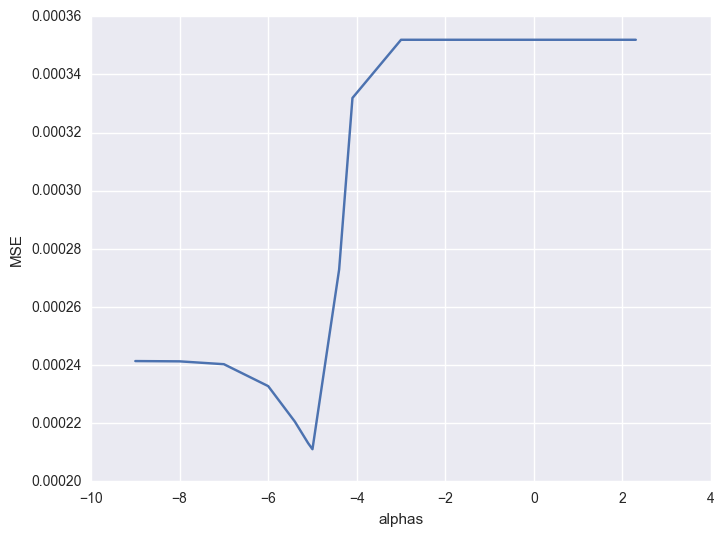

In [20]:
X_train, X_test = X_trans[:2300].copy(), X_trans[2300:].copy()
y_train, y_test = y_sc[:2300].copy(), y_sc[2300:].copy()

all_mse=[]
alphas=[1e-9,1e-8,1e-7, 1e-6,4e-6, 8e-6, 1e-5,4e-5, 8e-5, 1e-3,1e-1,1,100,200]

for a in alphas:
    est=Lasso(alpha = a)
    fit = est.fit(X_train,y_train)
    yp = est.predict(X_test).reshape(-1, 1)
    mse=np.mean((y_test-yp)**2)
    all_mse.append(mse)
    print ("alpha" ,a, ", R_squared training error: ", est.score(X_train,y_train) , 
           ", R_squared test error:",est.score(X_test,y_test))

plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [21]:
est=Lasso(alpha=1e-6)
est.fit(X_train,y_train)
est.alpha

zipped=zip(X_trans.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)

df_f  = pd.DataFrame(features, columns=('features','Lasso_coef'))


df_f = df_f.sort(['Lasso_coef'], ascending = False)
df_f= df_f.set_index(['features'])
df_f_2 = df_f[df_f.Lasso_coef != 0]

iplot(df_f_2.iplot(asFigure=True,
               layout = layout,
                kind = 'bar',
               xTitle = '',
               yTitle = 'P-Value',
               title = 'Selected Features'))

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



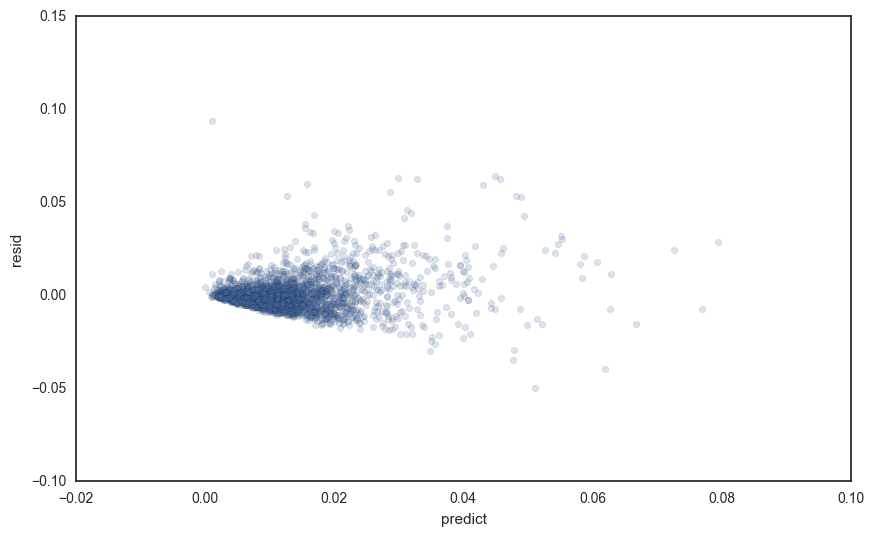

In [22]:
est=Lasso(alpha=1e-5)
est.fit(X_train,y_train)
est.alpha

zipped=zip(X_trans.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)


data = pd.DataFrame()
data['predict']=est.predict(X_trans)
data['resid']=y_sc-est.predict(X_trans).reshape(-1, 1)
with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

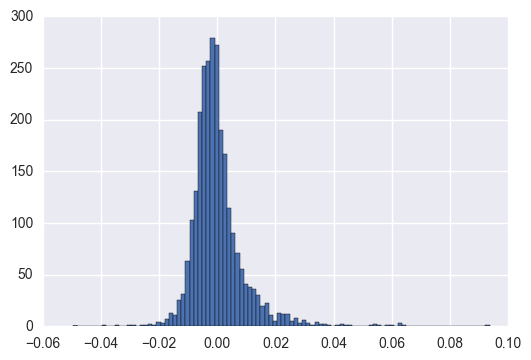

In [23]:
data.resid.hist(bins=100)

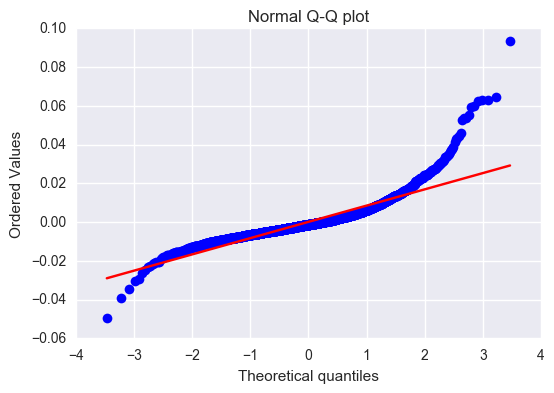

In [24]:
stats.probplot(data['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

<a id= "6"></a>
## Second degree polynomial Features

[Return to top](#top)




In [25]:
output_df = PolynomialFeatures_labeled(X_trans,2)
output_df.head()

,Constant Term,adjusted_budget^1,theaters^1,month_1^1,month_4^1,month_5^1,month_6^1,month_7^1,month_8^1,month_9^1,...,director_stars[T.Tim Miller]^2,director_stars[T.Tim Miller]^1 x director_stars[T.Tom Shadyac]^1,director_stars[T.Tim Miller]^1 x director_stars[T.Wolfgang Petersen]^1,director_stars[T.Tim Miller]^1 x director_stars[T.Zack Snyder]^1,director_stars[T.Tom Shadyac]^2,director_stars[T.Tom Shadyac]^1 x director_stars[T.Wolfgang Petersen]^1,director_stars[T.Tom Shadyac]^1 x director_stars[T.Zack Snyder]^1,director_stars[T.Wolfgang Petersen]^2,director_stars[T.Wolfgang Petersen]^1 x director_stars[T.Zack Snyder]^1,director_stars[T.Zack Snyder]^2
0,1.0,0.000182,0.027593,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.000624,0.027593,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.000073,0.004640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.001148,0.021755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.000178,0.024059,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



alphas: 1e-11 , R_squared training error:  0.797354860542 , R_squared test error: -1.17075583497
alphas: 1e-10 , R_squared training error:  0.797328973665 , R_squared test error: -1.05435359795
alphas: 1e-09 , R_squared training error:  0.797033684655 , R_squared test error: -0.668427158586
alphas: 1e-08 , R_squared training error:  0.793139165412 , R_squared test error: 0.10652972186
alphas: 1e-07 , R_squared training error:  0.767162918075 , R_squared test error: 0.392708747483
alphas: 1e-06 , R_squared training error:  0.744855667423 , R_squared test error: 0.385242114472
alphas: 4e-06 , R_squared training error:  0.721598874465 , R_squared test error: 0.437056135711
alphas: 8e-06 , R_squared training error:  0.691346715742 , R_squared test error: 0.447084070667
alphas: 1e-05 , R_squared training error:  0.675851030964 , R_squared test error: 0.445105427205
alphas: 4e-05 , R_squared training error:  0.397724220155 , R_squared test error: 0.220141191034
alphas: 8e-05 , R_squared trai

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



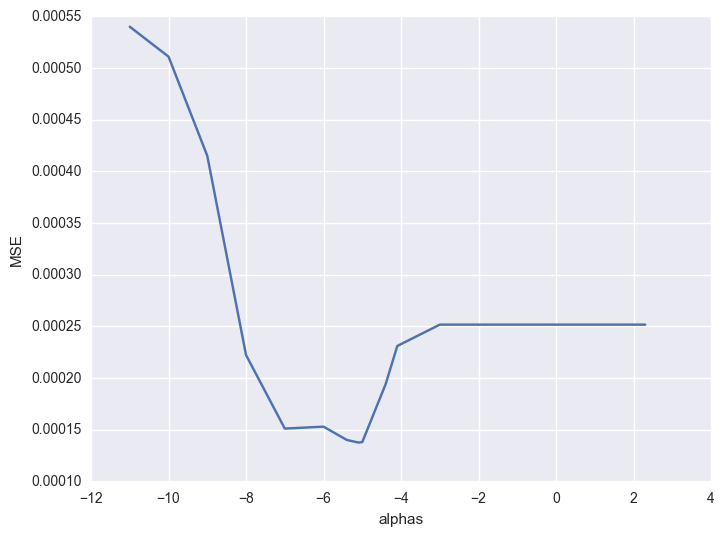

In [26]:
X_train, X_test = output_df[:2000].copy(), output_df[2000:].copy()
y_train, y_test = y_sc[:2000].copy(), y_sc[2000:].copy()

all_mse=[]
alphas=[1e-11, 1e-10, 1e-9,1e-8,1e-7, 1e-6,4e-6, 8e-6, 1e-5,4e-5, 8e-5, 1e-3,1e-1,1,100,200]

for a in alphas:
    est=Lasso(alpha = a,max_iter=2000)
    fit = est.fit(X_train,y_train)
    yp = est.predict(X_test).reshape(-1, 1)
    mse=np.mean((y_test-yp)**2)
    all_mse.append(mse)
    print ("alphas:",a, ", R_squared training error: ", est.score(X_train,y_train) , 
           ", R_squared test error:",est.score(X_test,y_test))

plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [27]:
est=Lasso(alpha=8e-6)
est.fit(X_train,y_train)
est.alpha

zipped=zip(X_train.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)

df_f  = pd.DataFrame(features, columns=('features','Lasso_coef'))
df_f = df_f.sort(['Lasso_coef'], ascending = False)
df_f= df_f.set_index(['features'])
df_f_2 = df_f[df_f.Lasso_coef != 0]

iplot(df_f_2.iplot(asFigure=True,
               layout = layout,
                kind = 'bar',
               xTitle = '',
               yTitle = '',
               title = 'Selected Features'))

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



In [28]:
df_f_2.head(10)

,Lasso_coef
features,
theaters^1,0.560810
adjusted_budget^1,0.173474
month_7^1 x director_stars[T.Christopher Nolan]^1,0.058679
first_stars[T.Tobey Maguire]^1 x director_stars[T.Sam Raimi]^1,0.035400
first_stars[T.Johnny Depp]^1 x director_stars[T.Gore Verbinski]^1,0.033051
first_stars[T.Daniel Radcliffe]^1,0.031459
director_stars[T.Chris Miller]^1,0.029035
month_5^1 x first_stars[T.Tobey Maguire]^1,0.027022
month_11^1 x director_stars[T.Chris Weitz]^1,0.025410


In [29]:
df_f_2.tail(10)

,Lasso_coef
features,
month_6^1 x first_stars[T.Mel Gibson]^1,-0.000074
first_stars[T.Mel Gibson]^1 x director_stars[T.Roland Emmerich]^1,-0.000077
month_8^1,-0.000216
month_10^1,-0.000322
month_4^1,-0.000612
month_9^1,-0.000864
month_11^1 x director_stars[T.Brett Ratner]^1,-0.001569
month_6^1 x director_stars[T.Roland Emmerich]^1,-0.004277
month_12^1 x first_stars[T.Jim Carrey]^1,-0.007949


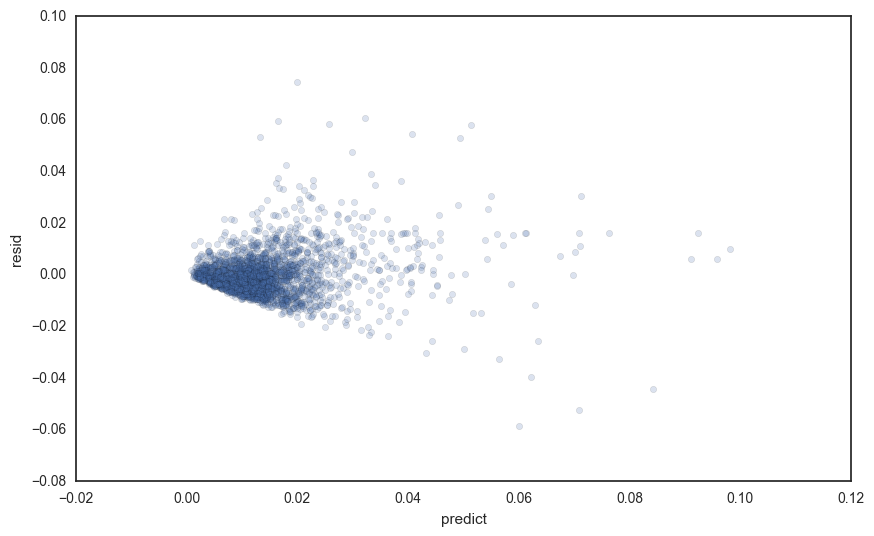

In [30]:
est=Lasso(alpha=8e-6)
est.fit(X_train,y_train)
est.alpha

zipped=zip(X_trans.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)


data = pd.DataFrame()
data['predict']=est.predict(output_df)
data['resid']=y_sc-est.predict(output_df).reshape(-1, 1)
with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

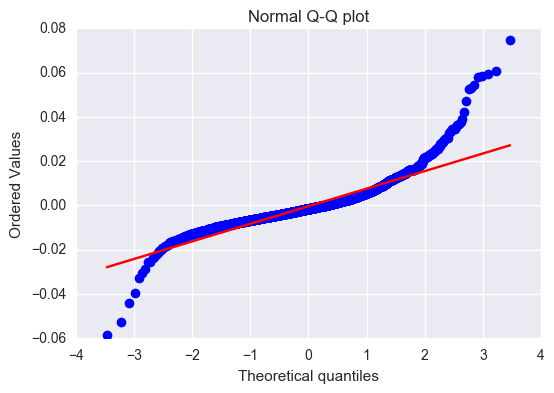

In [31]:
stats.probplot(data['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [32]:
df_p_2 = df_f[df_f.Lasso_coef != 0]
tt = df_p_2.index
df_p = output_df[tt]

X_trans2 = df_p.join(intercept)
model = sm.OLS(y_sc, X_trans2)
fit = model.fit()
summ = fit.summary()
summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       adjusted_opening   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     47.09
Date:                Sun, 29 Jan 2017   Prob (F-statistic):               0.00
Time:                        20:00:22   Log-Likelihood:                 9014.1
No. Observations:                2647   AIC:                        -1.782e+04
Df Residuals:                    2541   BIC:                        -1.719e+04
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================
                                                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------------------------------
theaters^1                                                                  0.7018      0.027     25.601      0.000         0.648     0.756
adjusted_budget^1                                                           0.1904      0.015     13.010      0.000         0.162     0.219
month_7^1 x director_stars[T.Christopher Nolan]^1                           0.0455      0.006      7.127      0.000         0.033     0.058
first_stars[T.Tobey Maguire]^1 x director_stars[T.Sam Raimi]^1              0.0319      0.012      2.742      0.006         0.009     0.055
first_stars[T.Johnny Depp]^1 x director_stars[T.Gore Verbinski]^1           0.0154      0.007      2.185      0.029         0.002     0.029
first_stars[T.Daniel Radcliffe]^1                                           0.0226      0.004      5.467      0.000         0.014     0.031
director_stars[T.Chris Miller]^1                                           -0.0006      0.004     -0.140      0.889        -0.009     0.007
month_5^1 x first_stars[T.Tobey Maguire]^1                                  0.0367      0.010      3.638      0.000         0.017     0.056
month_11^1 x director_stars[T.Chris Weitz]^1                                0.0203      0.006      3.510      0.000         0.009     0.032
director_stars[T.Robert Benton]^1                                           0.0151      0.003      5.198      0.000         0.009     0.021
month_5^1 x director_stars[T.Steven Spielberg]^1                            0.0260      0.006      4.571      0.000         0.015     0.037
first_stars[T.Shia LaBeouf]^1 x director_stars[T.Michael Bay]^1             0.0300      0.006      5.105      0.000         0.018     0.042
first_stars[T.Robert Downey Jr.]^1                                          0.0346      0.003      9.956      0.000         0.028     0.041
first_stars[T.Sam Neill]^1                                                  0.0143      0.003      4.838      0.000         0.008     0.020
director_stars[T.Andrew Stanton]^1                                          0.0083      0.003      2.854      0.004         0.003     0.014
month_5^1 x director_stars[T.Stephen Sommers]^1                             0.0233      0.005      4.876      0.000         0.014     0.033
month_11^1 x first_stars[T.Kristen Stewart]^1                               0.0187      0.009      2.038      0.042         0.001     0.037
director_stars[T.John Lasseter]^1                                           0.0093      0.002      4.949      0.000         0.006     0.013
director_stars[T.Pete Docter]^1                                             0.0123      0.003      4.219      0.000         0.007     0.018
dir

<a id= "7"></a>
## Third degree polynomial Features

[Return to top](#top)

In [33]:
output_df_3 = PolynomialFeatures_labeled(X_trans,3)
output_df_3.head()

,Constant Term,adjusted_budget^1,theaters^1,month_1^1,month_4^1,month_5^1,month_6^1,month_7^1,month_8^1,month_9^1,...,director_stars[T.Tom Shadyac]^3,director_stars[T.Tom Shadyac]^2 x director_stars[T.Wolfgang Petersen]^1,director_stars[T.Tom Shadyac]^2 x director_stars[T.Zack Snyder]^1,director_stars[T.Tom Shadyac]^1 x director_stars[T.Wolfgang Petersen]^2,director_stars[T.Tom Shadyac]^1 x director_stars[T.Wolfgang Petersen]^1 x director_stars[T.Zack Snyder]^1,director_stars[T.Tom Shadyac]^1 x director_stars[T.Zack Snyder]^2,director_stars[T.Wolfgang Petersen]^3,director_stars[T.Wolfgang Petersen]^2 x director_stars[T.Zack Snyder]^1,director_stars[T.Wolfgang Petersen]^1 x director_stars[T.Zack Snyder]^2,director_stars[T.Zack Snyder]^3
0,1.0,0.000182,0.027593,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.000624,0.027593,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.000073,0.004640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.001148,0.021755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.000178,0.024059,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



alphas: 1e-11 , R_squared training error:  0.818610486941 , R_squared test error: -9.73681444591
alphas: 1e-10 , R_squared training error:  0.817597081426 , R_squared test error: -8.30591097154
alphas: 1e-09 , R_squared training error:  0.814394408204 , R_squared test error: -3.96247172815
alphas: 1e-08 , R_squared training error:  0.801712522852 , R_squared test error: 0.12008309728
alphas: 1e-07 , R_squared training error:  0.767498076094 , R_squared test error: 0.405325784732
alphas: 1e-06 , R_squared training error:  0.745015062116 , R_squared test error: 0.38699870237
alphas: 1e-05 , R_squared training error:  0.675852195746 , R_squared test error: 0.445144067659
alphas: 0.0001 , R_squared training error:  0.142085036207 , R_squared test error: 0.0673746845143
alphas: 0.001 , R_squared training error:  0.0 , R_squared test error: -0.0116972492717
alphas: 0.1 , R_squared training error:  0.0 , R_squared test error: -0.0116972492717
alphas: 1 , R_squared training error:  0.0 , R_squ

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



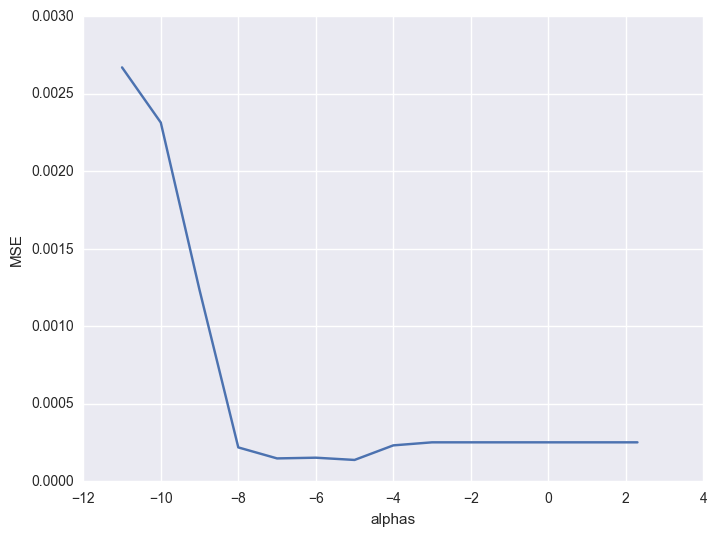

In [34]:
X_train, X_test = output_df_3[:2000].copy(), output_df_3[2000:].copy()
y_train, y_test = y_sc[:2000].copy(), y_sc[2000:].copy()

all_mse=[]
alphas=[1e-11, 1e-10, 1e-9,1e-8,1e-7, 1e-6,1e-5,1e-4, 1e-3, 1e-1,1,100,200]

for a in alphas:
    est=Lasso(alpha = a,max_iter=2000)
    fit = est.fit(X_train,y_train)
    yp = est.predict(X_test).reshape(-1, 1)
    mse=np.mean((y_test-yp)**2)
    all_mse.append(mse)
    print ("alphas:",a, ", R_squared training error: ", est.score(X_train,y_train) , 
           ", R_squared test error:",est.score(X_test,y_test))

plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [35]:
est=Lasso(alpha=1e-5)
est.fit(X_train,y_train)
est.alpha

zipped=zip(X_train.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)

df_f  = pd.DataFrame(features, columns=('features','Lasso_coef'))
df_f = df_f.sort(['Lasso_coef'], ascending = False)
df_f= df_f.set_index(['features'])
df_p_2 = df_f[df_f.Lasso_coef != 0]

iplot(df_p_2.iplot(asFigure=True,
               layout = layout,
                kind = 'bar',
               xTitle = '',
               yTitle = '',
               title = 'Selected Features'))

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



In [36]:
df_p_2.head(10)

,Lasso_coef
features,
theaters^1,0.526837
adjusted_budget^1,0.176675
month_7^1 x director_stars[T.Christopher Nolan]^1,0.054776
first_stars[T.Tobey Maguire]^1 x director_stars[T.Sam Raimi]^1,0.035770
first_stars[T.Johnny Depp]^1 x director_stars[T.Gore Verbinski]^1,0.032205
first_stars[T.Daniel Radcliffe]^1,0.031732
month_5^1 x first_stars[T.Tobey Maguire]^1,0.024489
director_stars[T.Chris Miller]^1,0.024062
month_11^1 x director_stars[T.Chris Weitz]^1,0.021558


In [37]:
df_p_2.tail(10)

,Lasso_coef
features,
month_4^2,-0.000085
month_8^1,-0.000123
month_12^2,-0.000151
month_10^1,-0.000321
month_4^1,-0.000486
month_12^2 x first_stars[T.Jim Carrey]^1,-0.000653
month_5^2 x director_stars[T.Jay Roach]^1,-0.000844
month_9^1,-0.000916
month_5^1 x director_stars[T.Jay Roach]^1,-0.004233


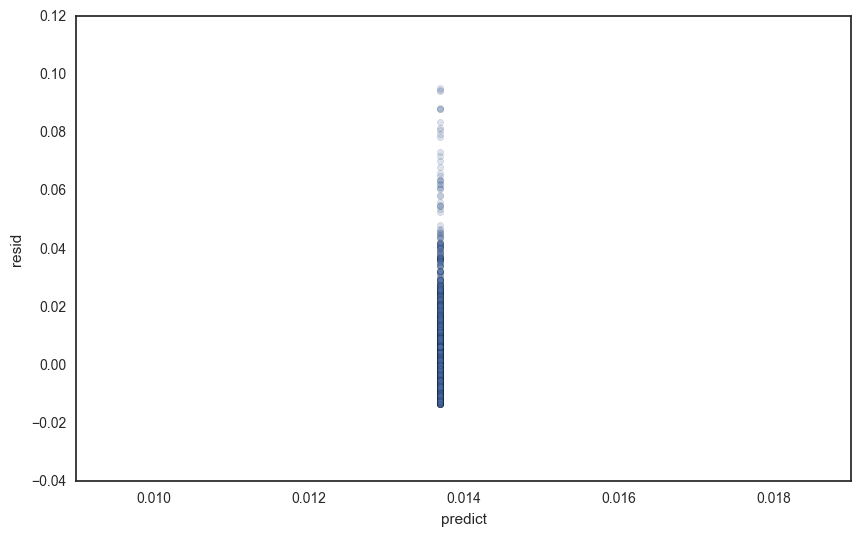

In [38]:
est=Lasso(alpha=100)
est.fit(output_df_3,y_sc)
est.alpha

zipped=zip(output_df_3.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)


data = pd.DataFrame()
data['predict']=est.predict(output_df_3)
data['resid']=y_sc-est.predict(output_df_3).reshape(-1, 1)
with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

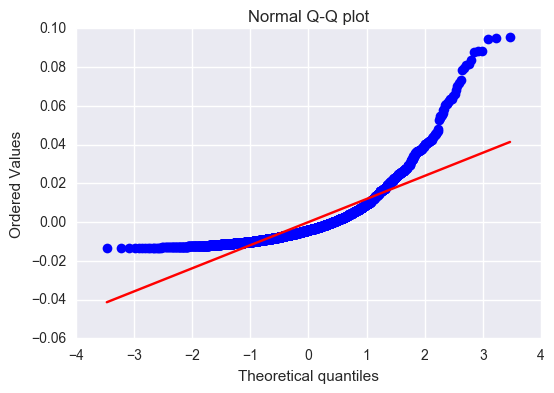

In [39]:
stats.probplot(data['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()